In [2]:
import os, math, copy
import matplotlib.pyplot as plt
from pybeta_asymmetry import *
import warnings
warnings.filterwarnings(action='ignore')

In [209]:
def drawdown(returns): # Calculate Drawdowns
    cumulative = returns
    highwatermark = cumulative.cummax()
    drawdown = (cumulative / highwatermark)-1
    return drawdown

def max_dd(returns): # Calculate Maxium Drawdowns
    return np.min(drawdown(returns))

def cagr(data): # Calculate CAGR
    years = data.index[-1].year - data.index[0].year
    return (data.iloc[-1] ** (1 / years)) -1
    
def sharpe(returns, days): # Calculate Sharpe Ratio
    return cagr((returns+1).cumprod()) / (np.std(returns) * np.sqrt(days))

def cum(returns): # Calculate Cummlative Returns from Returns
    return (returns+1).cumprod()

def weight_fill(raw, momentum): # Function for matching resampled data with another data
    raw.index = pd.to_datetime(raw.index)
    dummy = pd.DataFrame(pd.to_datetime(np.array(raw.index)), columns=['tmp'])
    dummy.index = raw.index
    dummy['tmp'] = pd.to_datetime(dummy.index)

    momentum.index = pd.to_datetime(momentum.index)
    momentum['tmp'] = pd.to_datetime(momentum.index)

    result = pd.merge(dummy, momentum, on='tmp', how='left')
    result.index = pd.to_datetime(result["tmp"])
    result = result.drop("tmp", axis=1)
    result = result.pad()
    return result

In [325]:
# Load US Data 
loc = os.getcwd() + "/" 
# stock = pd.read_csv(loc+"Data/CRSP_CLOSE_PP.csv", index_col="date").drop("Unnamed: 0", axis=1)
stock = pd.read_csv(loc+"Data/CRSP_CLOSE_FINAL.csv", index_col="date", date_format="%Y-%m-%d")
market = pd.read_csv(loc+"Data/SPX.csv")[["Date","Close"]]
# screen = pd.read_csv(loc+"Data/CRSP_CONSTITUENTS_PP.csv", index_col="date")
screen = pd.read_csv(loc+"Data/CRSP_CONSTITUENTS_FINAL.csv", index_col="date", date_format="%Y-%m-%d")
screen = screen.applymap(lambda x: np.nan if x==0 else (int(x) if not math.isnan(x) else np.nan))
stock = np.abs(stock)

### Preprocess Data
stock.index = pd.to_datetime(stock.index, format="%Y%m%d")
market.columns = ["date","CLOSE"]
market.index = pd.to_datetime(market["date"])
market = market.drop("date", axis=1)
screen.index = pd.to_datetime(screen.index)

for col in stock.columns:
    if col not in screen.columns:
        stock = stock.drop(col, axis=1)

for idx in market.index:
    if idx not in stock.index:
        market = market.drop(idx, axis=0)

# Calculate Stock Return
stock_return = stock.pct_change()
market_return = market.pct_change()

dummy_matrix = stock.copy()
dummy_matrix[dummy_matrix.isna() == False] = 0

stock_return = stock_return + dummy_matrix
stock_return = stock_return.dropna(how="all", axis=0)
market_return = market_return.dropna(how="all", axis=0)

# Preprocess 2
for idx in screen.index:
    if idx not in stock_return.index:
        screen = screen.drop(idx, axis=0)

In [5]:
### Winsorize the Stock Return
winsor_stock_return = PREPROCESSOR.do_winsorize(stock_return, method='quantile', quantile=0.025, hurdle=0.25)
# winsor_stock_return = PREPROCESSOR.replace_extreme(stock_return, 0.5)
# winsor_stock_return = stock_return.copy() ### When Using no preprocessed stock return

Please Wait...


Winsorizing...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:03<00:00, 1807.53it/s]


In [ ]:
# Beta Calculation - upBeta
upBeta = BETA_CALCULATOR()
upBeta.run(
    stock_return=winsor_stock_return.copy(), # pd.DataFrame (columns:unique code, index:date, values:return)
    market_return=market_return.copy(), # pd.DataFrame (columns:unique code, index:date, values:return)
    window=252, # int
    type="up", # str ('up', 'down', 'all')
    white=False, # White Standard Error (used in OLS only)
)
upBeta.beta = upBeta.beta * screen
upBeta.beta.to_csv(loc+"Export/us_upBeta.csv") # Save the Result

In [ ]:
# Beta Calculation - downBeta
downBeta = BETA_CALCULATOR()
downBeta.run(
    stock_return=winsor_stock_return.copy(), # pd.DataFrame (columns:unique code, index:date, values:return)
    market_return=market_return.copy(), # pd.DataFrame (columns:unique code, index:date, values:return)
    window=252, # int
    type="down", # str ('up', 'down', 'all')
    white=False, # White Standard Error (used in OLS only)
)
downBeta.beta = downBeta.beta * screen
downBeta.beta.to_csv(loc+"Export/us_downBeta.csv") # Save the Result

In [376]:
### Weight Calculation ###
upbeta_ = pd.read_csv('./Export/us_upBeta.csv', index_col='date', date_format='%Y-%m-%d')
downbeta_ = pd.read_csv('./Export/us_downBeta.csv', index_col='date', date_format='%Y-%m-%d')
myStrategy = STRATEGY()
myStrategy.straddle(
                upbeta=upbeta_,
                downbeta=downbeta_,
                long_stock_down_hurdle=0.85,
                short_stock_up_hurdle=1,#
                up_minus_down_hurdle=0.55,
                down_minus_up_hurdle=0.25
            )

Please Wait...


Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13668.62it/s]

Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


In [377]:
 # Backtesting
pf_return, pf_value = backtesting_sketch(
                            stock_return = stock_return,
                            etf_return = market_return,
                            weight = myStrategy.total_weight,
                            resample = 'w-fri' # Weekly Rebalancing
)


In [378]:
print("Beta-Asymmetry Strategy")
print("CAGR:", cagr(cum(pf_return)).values)
print("Sharpe:", sharpe(pf_return, days=52).values)
print("MDD:", max_dd(cum(pf_return)))
print("VOL:", cagr(cum(pf_return)).values / sharpe(pf_return, days=52).values)

Beta-Asymmetry Strategy
CAGR: [0.15103265]
Sharpe: [0.39232738]
MDD: -0.670939134850312
VOL: [0.38496586]


Calculating Momentum...: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 66405.01it/s]


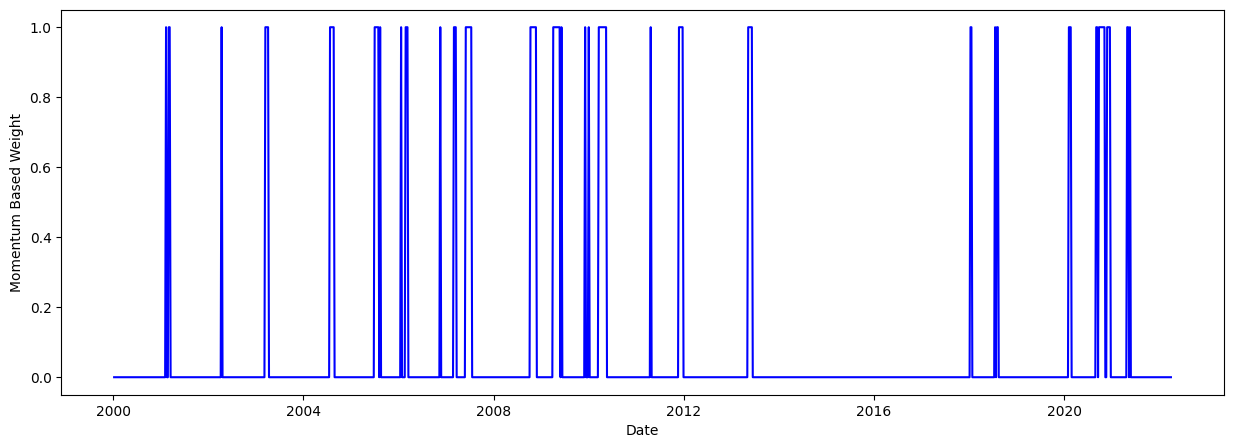

In [370]:
# Calculate Momentum Based Weight from returns of Virtual Portfolio
# Momentums are calucatled automatically without forward looking bias
mom_weight = momentum(
                pf_value = pf_value,
                lookback =10,
                method = 'hurdle_strict', hurdle=0.45)
# Plot Momentum Based Weight for Dynamic Optimization
plt.figure(figsize=(15,5))
plt.xlabel("Date", fontsize=10)
plt.ylabel("Momentum Based Weight", fontsize=10)
plt.plot(mom_weight, color='blue')

In [375]:
# Adjusted resampled weights
filled_weight = weight_fill(myStrategy.total_weight, mom_weight)
momStrategy = STRATEGY()
momStrategy.straddle(
    upbeta=upbeta_,
    downbeta=downbeta_,
    long_stock_down_hurdle=1.2,
    short_stock_up_hurdle=1.2,#
    up_minus_down_hurdle=0.35,
    down_minus_up_hurdle=0.35,
    momentum_weight = filled_weight
)

Please Wait...
(5597,)
(5597, 1)


Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15787.75it/s]

Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


SnP500 market
CAGR: [0.05297627]
Sharpe: [0.59337333]
MDD: -0.5677538894035712
VOL: [0.08927983]

Beta-Asymmetry Strategy
CAGR: [0.15103265]
Sharpe: [0.39232738]
MDD: -0.670939134850312
VOL: [0.38496586]

Beta-Asymmetry with strategy-based momentum
CAGR: [0.10171351]
Sharpe: [0.38291283]
MDD: -0.45171323994420365
VOL: [0.26563097]


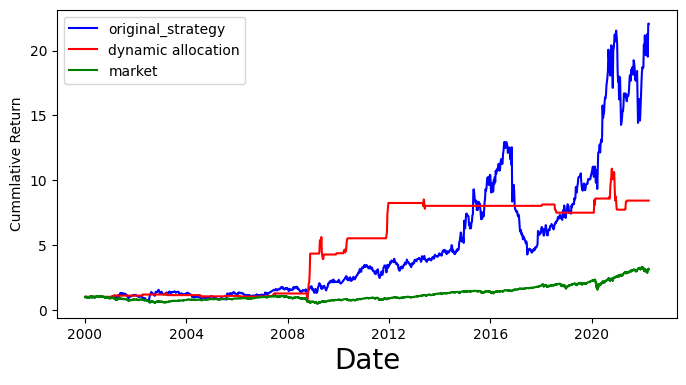

In [372]:
# Backtest the PF
mom_pf_return, mom_pf_value = backtesting_sketch(
                                    stock_return = stock_return,
                                    etf_return = market_return,
                                    weight = momStrategy.total_weight,
                                    resample = 'w-fri'
                                )

# Plot Cummlative Returns of PFs
# Blue-Virtual_PF, Red-Momentum_Based_Weight_Adjusted PF, Green-S&P500

plt.figure(figsize=(8,4))
plt.xlabel("Date", fontsize=20)
plt.ylabel("Cummlative Return", fontsize=10)

plt.plot((pf_return+1).cumprod(), color='blue')
plt.plot((mom_pf_return+1).cumprod(), color='red')
plt.plot((market_return+1).cumprod(), color='green')
plt.legend(['original_strategy', 'dynamic allocation', 'market'])

print("SnP500 market")
print("CAGR:", cagr(cum(market_return)).values)
print("Sharpe:", sharpe(market_return, days=52).values)
print("MDD:", max_dd(cum(market_return)))
print("VOL:", cagr(cum(market_return)).values / sharpe(market_return, days=52).values)
print()

print("Beta-Asymmetry Strategy")
print("CAGR:", cagr(cum(pf_return)).values)
print("Sharpe:", sharpe(pf_return, days=52).values)
print("MDD:", max_dd(cum(pf_return)))
print("VOL:", cagr(cum(pf_return)).values / sharpe(pf_return, days=52).values)

print()
print("Beta-Asymmetry with strategy-based momentum")
print("CAGR:", cagr(cum(mom_pf_return)).values)
print("Sharpe:", sharpe(mom_pf_return, days=52).values)
print("MDD:", max_dd(cum(mom_pf_return)))
print("VOL:", cagr(cum(mom_pf_return)).values / sharpe(mom_pf_return, days=52).values)

plt.show()

2000 ~ 2010
SnP500 market
CAGR: [-0.01448607]
Sharpe: [-0.14576318]
MDD: -0.5677538894035712
VOL: [0.09938083]

Beta-Asymmetry Strategy
CAGR: [0.12517022]
Sharpe: [0.30863622]
MDD: -0.4880511995417284
VOL: [0.40555908]

Beta-Asymmetry with strategy-based momentum
CAGR: [0.18618904]
Sharpe: [0.52124914]
MDD: -0.45171323994420365
VOL: [0.35719778]


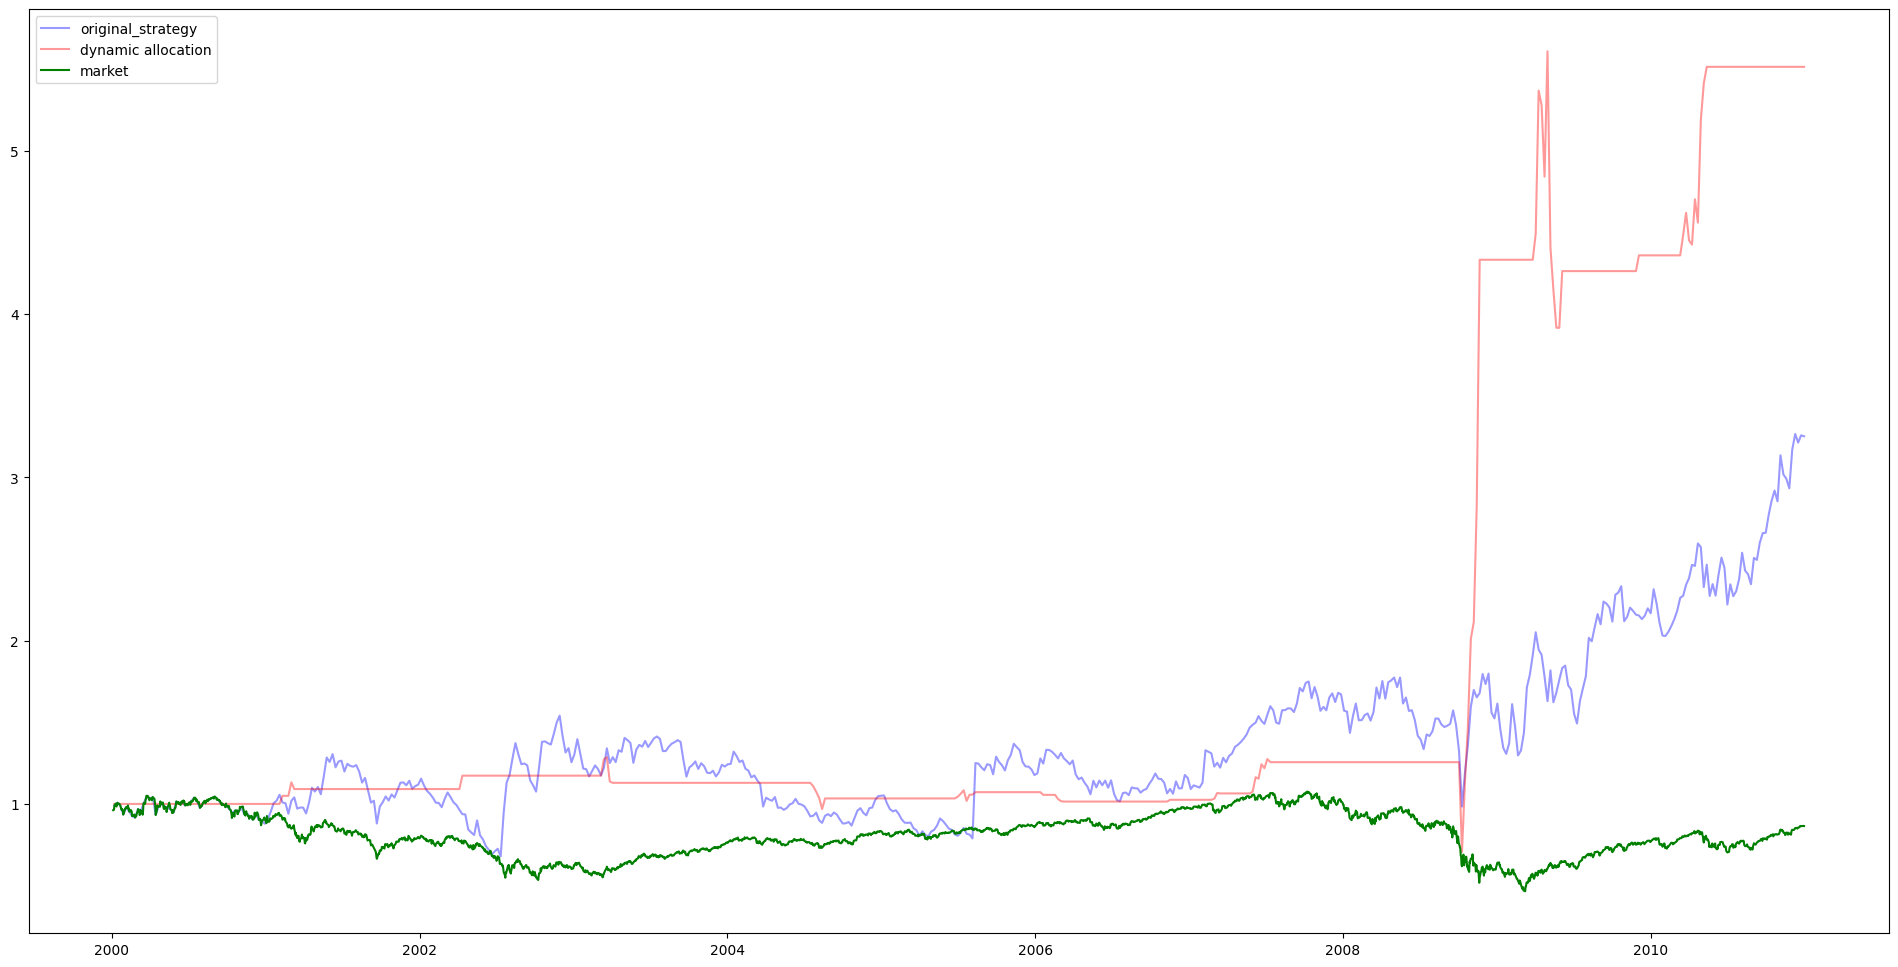

2010 ~ 2020
SnP500 market
CAGR: [0.1291249]
Sharpe: [1.62477187]
MDD: -0.3392495902426059
VOL: [0.07947264]

Beta-Asymmetry Strategy
CAGR: [0.25328342]
Sharpe: [0.7113016]
MDD: -0.6709391348503122
VOL: [0.35608443]

Beta-Asymmetry with strategy-based momentum
CAGR: [0.05962124]
Sharpe: [0.45780675]
MDD: -0.28561369967865746
VOL: [0.13023233]


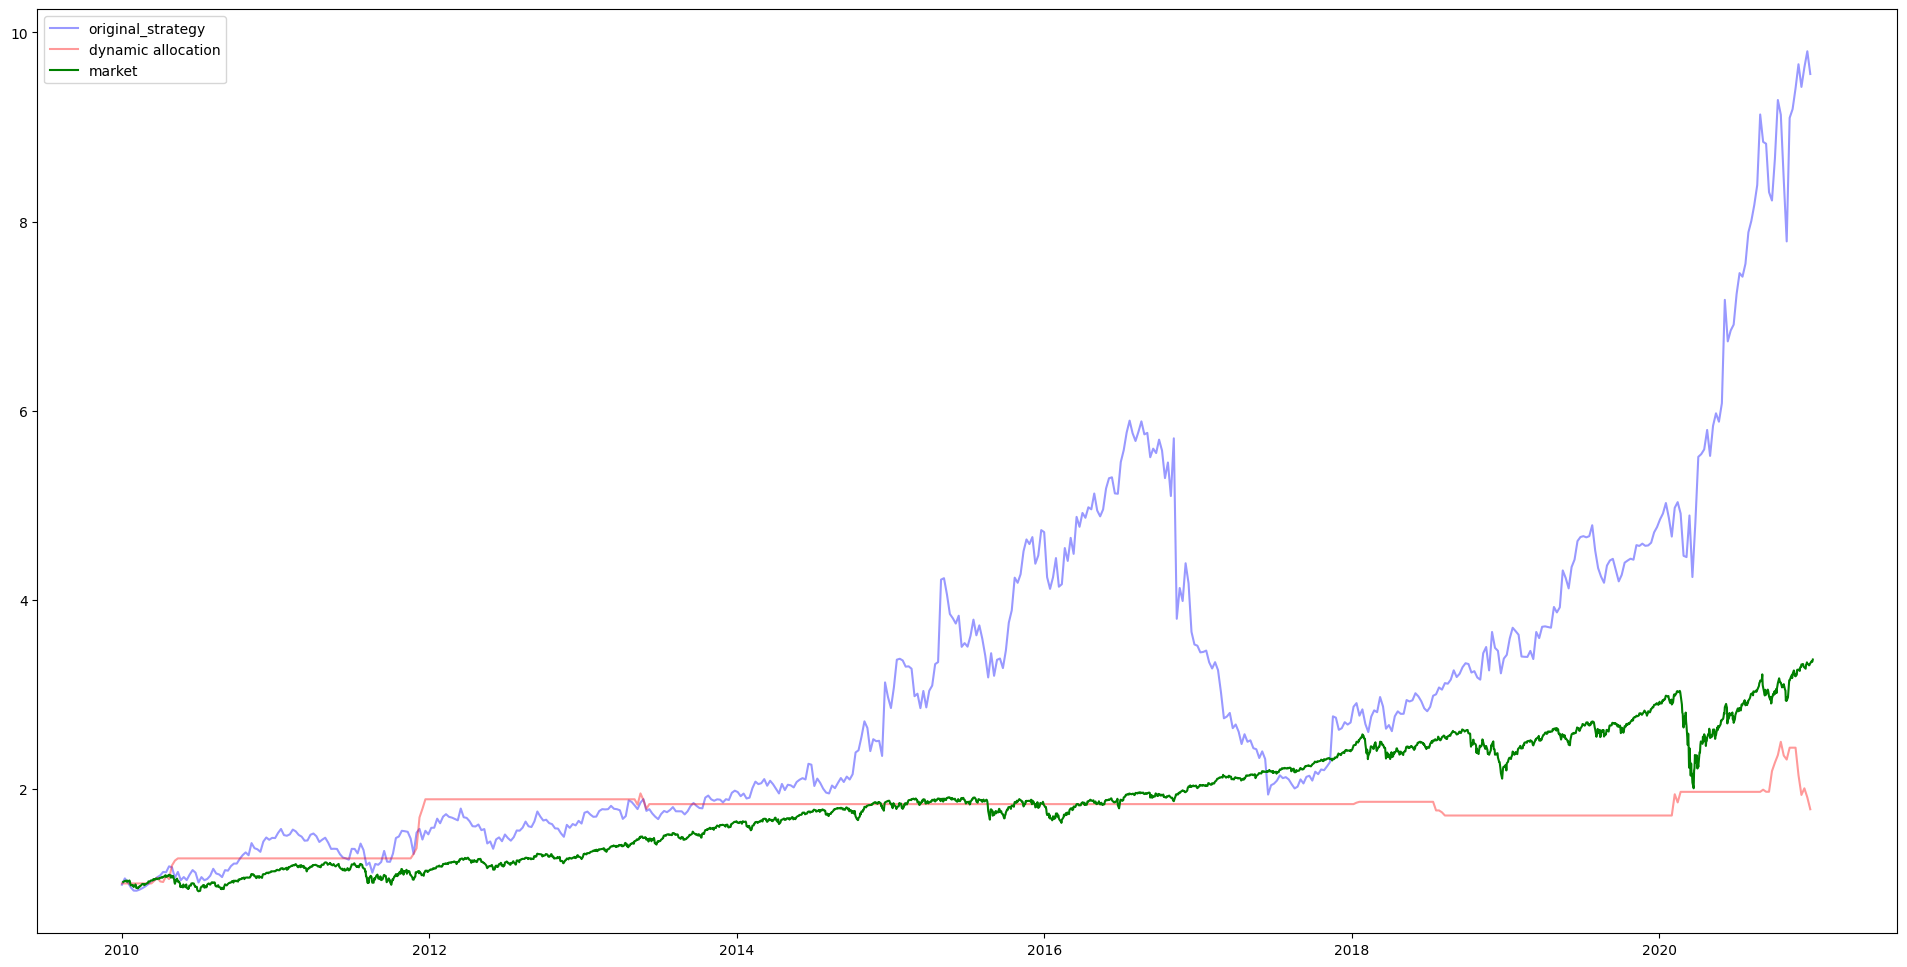

In [373]:
# Visuaized the Periodic Performance of Real PF
for start_year in [2000,2010]:
    end_year = str(start_year+10)
    start_year = str(start_year)
    print(start_year, "~", end_year)
    print("SnP500 market")
    print("CAGR:", cagr(cum(market_return[start_year:end_year])).values)
    print("Sharpe:", sharpe(market_return[start_year:end_year], days=52).values)
    print("MDD:", max_dd(cum(market_return[start_year:end_year])))
    print("VOL:", cagr(cum(market_return[start_year:end_year])).values / sharpe(market_return[start_year:end_year], days=52).values)
    print()

    
    print("Beta-Asymmetry Strategy")
    print("CAGR:", cagr(cum(pf_return[start_year:end_year])).values)
    print("Sharpe:", sharpe(pf_return[start_year:end_year], days=52).values)
    print("MDD:", max_dd(cum(pf_return[start_year:end_year])))
    print("VOL:", cagr(cum(pf_return[start_year:end_year])).values / sharpe(pf_return[start_year:end_year], days=52).values)
    
    print()
    print("Beta-Asymmetry with strategy-based momentum")
    print("CAGR:", cagr(cum(mom_pf_return[start_year:end_year])).values)
    print("Sharpe:", sharpe(mom_pf_return[start_year:end_year], days=52).values)
    print("MDD:", max_dd(cum(mom_pf_return[start_year:end_year])))
    print("VOL:", cagr(cum(mom_pf_return[start_year:end_year])).values / sharpe(mom_pf_return[start_year:end_year], days=52).values)
    plt.figure(figsize=(24,12))
    plt.plot((pf_return+1)[start_year:end_year].cumprod(), color='blue', alpha=0.4)
    plt.plot((mom_pf_return+1)[start_year:end_year].cumprod(), color='red', alpha=0.4)
    plt.plot((market_return+1)[start_year:end_year].cumprod(), color='green')
    plt.legend(['original_strategy', 'dynamic allocation', 'market'])
    plt.show()

### greedy search (hyperparameter tuning)

In [280]:
from itertools import product
long_stock_down_hurdle = np.arange(0.85, 1.36, 0.1)
short_stock_up_hurdle = np.arange(1.0, 1.31, 0.1)
up_minus_down_hurdle=np.arange(0.45, 0.66, 0.1)
down_minus_up_hurdle=np.arange(0.1, 0.31, 0.1)
items = [long_stock_down_hurdle, short_stock_up_hurdle, up_minus_down_hurdle, down_minus_up_hurdle]
all_comb = list(product(*items))
print(len(all_comb))

216


In [282]:
maxi = -100
mini = -100
comb = all_comb[0]
for x in tqdm(all_comb):
    myStrategy = STRATEGY()
    myStrategy.straddle(
                    upbeta=upbeta_,
                    downbeta=downbeta_,
                    long_stock_down_hurdle=x[0],
                    short_stock_up_hurdle=x[1],
                    up_minus_down_hurdle=x[2],
                    down_minus_up_hurdle=x[3]
                )
    pf_return, pf_value = backtesting_sketch(
                            stock_return = stock_return,
                            etf_return = market_return,
                            weight = myStrategy.total_weight,
                            resample = 'w-fri' # Weekly Rebalancing
    )
    sharpe_ = sharpe(pf_return, days=52).values[0]
    mdd_ = max_dd(cum(pf_return))
    if (sharpe_ >= maxi):
        maxi = sharpe_
        mini = mdd_
        comb = x

  0%|                                                                                                                                  | 0/216 [00:00<?, ?it/s]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13377.06it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12807.05it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  0%|▌                                                                                                                         | 1/216 [00:06<23:14,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12964.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12944.18it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  1%|█▏                                                                                                                        | 2/216 [00:12<22:55,  6.43s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14422.20it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14589.77it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  1%|█▋                                                                                                                        | 3/216 [00:19<23:12,  6.54s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 11377.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14660.97it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  2%|██▏                                                                                                                   | 4/216 [17:19<23:57:04, 406.72s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12726.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12941.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  2%|██▋                                                                                                                   | 5/216 [33:44<36:03:52, 615.32s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12864.42it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12984.91it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  3%|███▎                                                                                                                  | 6/216 [33:51<23:48:49, 408.24s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12829.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12948.23it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  3%|███▊                                                                                                                  | 7/216 [33:57<16:04:27, 276.88s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12874.01it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12892.99it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  4%|████▎                                                                                                                 | 8/216 [34:04<11:01:19, 190.77s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12917.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12982.55it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  4%|████▉                                                                                                                  | 9/216 [34:10<7:39:12, 133.10s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12923.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12894.74it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  5%|█████▌                                                                                                                 | 10/216 [34:16<5:22:27, 93.92s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12837.87it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12956.98it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  5%|██████                                                                                                                 | 11/216 [34:22<3:49:24, 67.14s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12931.32it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12890.51it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  6%|██████▌                                                                                                                | 12/216 [34:29<2:45:32, 48.69s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12930.64it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13008.81it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  6%|███████▏                                                                                                               | 13/216 [34:35<2:01:17, 35.85s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12955.36it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13025.85it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  6%|███████▋                                                                                                               | 14/216 [34:42<1:30:50, 26.98s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13009.11it/s]

  7%|████████▎                                                                                                              | 15/216 [34:48<1:09:43, 20.82s/it]

Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias
Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13032.55it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12955.87it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  7%|████████▉                                                                                                                | 16/216 [34:55<54:49, 16.45s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13035.13it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13007.33it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  8%|█████████▌                                                                                                               | 17/216 [35:01<44:33, 13.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13025.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12981.35it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  8%|██████████                                                                                                               | 18/216 [35:07<37:21, 11.32s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12960.55it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13064.80it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  9%|██████████▋                                                                                                              | 19/216 [35:14<32:28,  9.89s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13059.00it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13025.04it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


  9%|███████████▏                                                                                                             | 20/216 [35:20<28:58,  8.87s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13001.10it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13063.92it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 10%|███████████▊                                                                                                             | 21/216 [35:27<26:20,  8.11s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13045.46it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12986.69it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 10%|████████████▎                                                                                                            | 22/216 [35:33<24:36,  7.61s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12956.91it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13046.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 11%|████████████▉                                                                                                            | 23/216 [35:40<23:16,  7.24s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13050.16it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13081.10it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 11%|█████████████▍                                                                                                           | 24/216 [35:46<22:22,  6.99s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13066.14it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12853.85it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 12%|██████████████                                                                                                           | 25/216 [35:53<21:54,  6.88s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13054.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12994.97it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 12%|██████████████▌                                                                                                          | 26/216 [35:59<21:23,  6.75s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13037.96it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12974.40it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 12%|███████████████▏                                                                                                         | 27/216 [36:05<20:55,  6.64s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12934.19it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13047.62it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 13%|███████████████▋                                                                                                         | 28/216 [36:12<20:27,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13047.14it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12940.42it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 13%|████████████████▏                                                                                                        | 29/216 [36:18<20:14,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12947.27it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13034.10it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 14%|████████████████▊                                                                                                        | 30/216 [36:25<20:06,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12936.67it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12942.18it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 14%|█████████████████▎                                                                                                       | 31/216 [36:31<19:56,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13002.38it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13040.05it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 15%|█████████████████▉                                                                                                       | 32/216 [36:38<19:55,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12978.92it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12993.68it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 15%|██████████████████▍                                                                                                      | 33/216 [36:44<20:00,  6.56s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13044.47it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13045.95it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 16%|███████████████████                                                                                                      | 34/216 [36:51<19:53,  6.56s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13073.69it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13003.43it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 16%|███████████████████▌                                                                                                     | 35/216 [36:57<19:43,  6.54s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13013.22it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13017.22it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 17%|████████████████████▏                                                                                                    | 36/216 [37:04<19:36,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12960.31it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13024.22it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 17%|████████████████████▋                                                                                                    | 37/216 [37:10<19:32,  6.55s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12988.43it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13056.78it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 18%|█████████████████████▎                                                                                                   | 38/216 [37:17<19:28,  6.56s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13009.35it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12861.23it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 18%|█████████████████████▊                                                                                                   | 39/216 [37:24<19:22,  6.57s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13022.43it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 10290.50it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 19%|██████████████████████▍                                                                                                  | 40/216 [37:30<19:16,  6.57s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13026.37it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13008.41it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 19%|██████████████████████▉                                                                                                  | 41/216 [37:37<19:09,  6.57s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12983.85it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12988.40it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 19%|███████████████████████▌                                                                                                 | 42/216 [37:43<19:05,  6.58s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12914.18it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12924.43it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 20%|████████████████████████                                                                                                 | 43/216 [37:50<18:42,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12951.11it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13019.61it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 20%|████████████████████████▋                                                                                                | 44/216 [37:56<18:33,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13021.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12998.95it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 21%|█████████████████████████▏                                                                                               | 45/216 [38:03<18:30,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12972.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12944.22it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 21%|█████████████████████████▊                                                                                               | 46/216 [38:09<18:20,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13014.75it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13033.76it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 22%|██████████████████████████▎                                                                                              | 47/216 [38:16<18:19,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13081.84it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13048.48it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 22%|██████████████████████████▉                                                                                              | 48/216 [38:22<18:01,  6.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13000.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12989.46it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 23%|███████████████████████████▍                                                                                             | 49/216 [38:28<17:53,  6.43s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13000.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13079.49it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 23%|████████████████████████████                                                                                             | 50/216 [38:35<17:48,  6.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13047.50it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12983.61it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 24%|████████████████████████████▌                                                                                            | 51/216 [38:41<17:40,  6.43s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13019.70it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13048.20it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 24%|█████████████████████████████▏                                                                                           | 52/216 [38:48<17:36,  6.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13021.70it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12977.86it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 25%|█████████████████████████████▋                                                                                           | 53/216 [38:54<17:37,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13028.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 10249.81it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 25%|██████████████████████████████▎                                                                                          | 54/216 [39:01<17:38,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13007.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13067.94it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 25%|██████████████████████████████▊                                                                                          | 55/216 [39:07<17:28,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12968.93it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13034.68it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 26%|███████████████████████████████▎                                                                                         | 56/216 [39:14<17:24,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12881.95it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13002.49it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 26%|███████████████████████████████▉                                                                                         | 57/216 [39:20<17:16,  6.52s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12962.17it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12965.29it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 27%|████████████████████████████████▍                                                                                        | 58/216 [39:27<17:11,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13038.25it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13003.47it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 27%|█████████████████████████████████                                                                                        | 59/216 [39:34<17:08,  6.55s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12878.12it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13041.85it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 28%|█████████████████████████████████▌                                                                                       | 60/216 [39:40<16:57,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13016.15it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13033.43it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 28%|██████████████████████████████████▏                                                                                      | 61/216 [39:47<16:59,  6.58s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13058.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13007.83it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 29%|██████████████████████████████████▋                                                                                      | 62/216 [39:53<16:51,  6.57s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12976.05it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13041.12it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 29%|███████████████████████████████████▎                                                                                     | 63/216 [40:00<16:35,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12983.70it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12964.66it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 30%|███████████████████████████████████▊                                                                                     | 64/216 [40:06<16:30,  6.52s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12916.13it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13007.72it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 30%|████████████████████████████████████▍                                                                                    | 65/216 [40:13<16:19,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13018.03it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12991.96it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 31%|████████████████████████████████████▉                                                                                    | 66/216 [40:19<16:14,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12954.38it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12943.49it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 31%|█████████████████████████████████████▌                                                                                   | 67/216 [40:26<16:13,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13075.70it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 10202.60it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 31%|██████████████████████████████████████                                                                                   | 68/216 [40:32<16:10,  6.56s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13248.66it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14527.41it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 32%|██████████████████████████████████████▋                                                                                  | 69/216 [40:39<15:56,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12759.69it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12880.64it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 32%|███████████████████████████████████████▏                                                                                 | 70/216 [40:45<15:46,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13574.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15387.49it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 33%|███████████████████████████████████████▊                                                                                 | 71/216 [40:51<15:31,  6.42s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 14316.95it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13085.20it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 33%|████████████████████████████████████████▎                                                                                | 72/216 [40:58<15:24,  6.42s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12838.63it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12855.08it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 34%|████████████████████████████████████████▉                                                                                | 73/216 [41:04<15:18,  6.42s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12859.75it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12892.39it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 34%|█████████████████████████████████████████▍                                                                               | 74/216 [41:11<15:18,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12768.07it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13009.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 35%|██████████████████████████████████████████                                                                               | 75/216 [41:17<15:12,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12821.90it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12950.80it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 35%|██████████████████████████████████████████▌                                                                              | 76/216 [41:24<15:05,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12886.52it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12983.46it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 36%|███████████████████████████████████████████▏                                                                             | 77/216 [41:30<14:57,  6.45s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12920.66it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12965.08it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 36%|███████████████████████████████████████████▋                                                                             | 78/216 [41:37<14:52,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12890.28it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12993.71it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 37%|████████████████████████████████████████████▎                                                                            | 79/216 [41:43<14:47,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12913.54it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12880.72it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 37%|████████████████████████████████████████████▊                                                                            | 80/216 [41:50<14:39,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12945.08it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12852.90it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 38%|█████████████████████████████████████████████▍                                                                           | 81/216 [41:56<14:30,  6.45s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12835.71it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 10142.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 38%|█████████████████████████████████████████████▉                                                                           | 82/216 [42:03<14:29,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12762.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12917.00it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 38%|██████████████████████████████████████████████▍                                                                          | 83/216 [42:09<14:21,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12989.66it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12940.77it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 39%|███████████████████████████████████████████████                                                                          | 84/216 [42:16<14:13,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13664.02it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13189.00it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 39%|███████████████████████████████████████████████▌                                                                         | 85/216 [42:22<14:05,  6.45s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12890.90it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12938.38it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 40%|████████████████████████████████████████████████▏                                                                        | 86/216 [42:28<13:55,  6.43s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12739.01it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12864.19it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 40%|████████████████████████████████████████████████▋                                                                        | 87/216 [42:35<13:48,  6.43s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12839.93it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12942.90it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 41%|█████████████████████████████████████████████████▎                                                                       | 88/216 [42:41<13:42,  6.42s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12906.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12943.14it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 41%|█████████████████████████████████████████████████▊                                                                       | 89/216 [42:48<13:36,  6.43s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12913.63it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12918.49it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 42%|██████████████████████████████████████████████████▍                                                                      | 90/216 [42:54<13:33,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13005.06it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12955.25it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 42%|██████████████████████████████████████████████████▉                                                                      | 91/216 [43:01<13:26,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12955.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12951.58it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 43%|███████████████████████████████████████████████████▌                                                                     | 92/216 [43:07<13:18,  6.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13054.62it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13378.02it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 43%|████████████████████████████████████████████████████                                                                     | 93/216 [43:14<13:17,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12901.96it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12949.19it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 44%|████████████████████████████████████████████████████▋                                                                    | 94/216 [43:20<13:12,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12877.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12999.32it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 44%|█████████████████████████████████████████████████████▏                                                                   | 95/216 [43:27<13:03,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12777.81it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12992.26it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 44%|█████████████████████████████████████████████████████▊                                                                   | 96/216 [43:33<13:01,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12947.06it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12828.42it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 45%|██████████████████████████████████████████████████████▎                                                                  | 97/216 [43:40<12:52,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12910.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12930.88it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 45%|██████████████████████████████████████████████████████▉                                                                  | 98/216 [43:46<12:44,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12919.62it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13005.24it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 46%|███████████████████████████████████████████████████████▍                                                                 | 99/216 [43:52<12:36,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12940.47it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12939.22it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 46%|███████████████████████████████████████████████████████▌                                                                | 100/216 [43:59<12:32,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12923.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12911.55it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 47%|████████████████████████████████████████████████████████                                                                | 101/216 [44:06<12:30,  6.52s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12815.17it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12980.47it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 47%|████████████████████████████████████████████████████████▋                                                               | 102/216 [44:12<12:22,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12811.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12801.17it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 48%|█████████████████████████████████████████████████████████▏                                                              | 103/216 [44:19<12:18,  6.54s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12813.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12939.61it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 48%|█████████████████████████████████████████████████████████▊                                                              | 104/216 [44:25<12:11,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12818.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12938.04it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 49%|██████████████████████████████████████████████████████████▎                                                             | 105/216 [44:32<12:02,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12969.08it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12959.31it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 49%|██████████████████████████████████████████████████████████▉                                                             | 106/216 [44:38<11:53,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12899.42it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12818.72it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 50%|███████████████████████████████████████████████████████████▍                                                            | 107/216 [44:45<11:46,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12796.53it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12743.88it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 50%|████████████████████████████████████████████████████████████                                                            | 108/216 [44:51<11:39,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12714.73it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12902.30it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 50%|████████████████████████████████████████████████████████████▌                                                           | 109/216 [44:57<11:31,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12937.63it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12915.57it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 51%|█████████████████████████████████████████████████████████████                                                           | 110/216 [45:04<11:27,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12870.19it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12927.12it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 51%|█████████████████████████████████████████████████████████████▋                                                          | 111/216 [45:11<11:20,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13527.82it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12886.34it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 52%|██████████████████████████████████████████████████████████████▏                                                         | 112/216 [45:17<11:12,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12958.54it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12973.56it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 52%|██████████████████████████████████████████████████████████████▊                                                         | 113/216 [45:23<11:05,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13611.71it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12994.79it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 53%|███████████████████████████████████████████████████████████████▎                                                        | 114/216 [45:30<10:58,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12807.26it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12954.25it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 53%|███████████████████████████████████████████████████████████████▉                                                        | 115/216 [45:36<10:55,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12828.36it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12922.70it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 54%|████████████████████████████████████████████████████████████████▍                                                       | 116/216 [45:43<10:51,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12820.25it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12914.97it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 54%|█████████████████████████████████████████████████████████████████                                                       | 117/216 [45:49<10:43,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12828.71it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12946.07it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 55%|█████████████████████████████████████████████████████████████████▌                                                      | 118/216 [45:56<10:35,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13390.43it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12777.16it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 55%|██████████████████████████████████████████████████████████████████                                                      | 119/216 [46:02<10:27,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13734.10it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12978.25it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 56%|██████████████████████████████████████████████████████████████████▋                                                     | 120/216 [46:09<10:19,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12948.02it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12880.08it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 56%|███████████████████████████████████████████████████████████████████▏                                                    | 121/216 [46:15<10:16,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12841.78it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12920.61it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 56%|███████████████████████████████████████████████████████████████████▊                                                    | 122/216 [46:22<10:08,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12867.67it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12918.23it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 57%|████████████████████████████████████████████████████████████████████▎                                                   | 123/216 [46:28<10:01,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12932.90it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12865.67it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 57%|████████████████████████████████████████████████████████████████████▉                                                   | 124/216 [46:35<09:56,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12875.52it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12906.40it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 58%|█████████████████████████████████████████████████████████████████████▍                                                  | 125/216 [46:41<09:48,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12901.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13033.98it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 58%|██████████████████████████████████████████████████████████████████████                                                  | 126/216 [46:48<09:45,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12895.48it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12952.99it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 59%|██████████████████████████████████████████████████████████████████████▌                                                 | 127/216 [46:54<09:37,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12900.57it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12979.69it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 59%|███████████████████████████████████████████████████████████████████████                                                 | 128/216 [47:01<09:29,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13350.99it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13509.41it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 60%|███████████████████████████████████████████████████████████████████████▋                                                | 129/216 [47:07<09:22,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13166.62it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13632.18it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 60%|████████████████████████████████████████████████████████████████████████▏                                               | 130/216 [47:14<09:23,  6.55s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12889.15it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13006.99it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 61%|████████████████████████████████████████████████████████████████████████▊                                               | 131/216 [47:20<09:16,  6.55s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12822.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12962.69it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 61%|█████████████████████████████████████████████████████████████████████████▎                                              | 132/216 [47:27<09:08,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12894.66it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12921.29it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 62%|█████████████████████████████████████████████████████████████████████████▉                                              | 133/216 [47:33<09:00,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13766.89it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12950.00it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 62%|██████████████████████████████████████████████████████████████████████████▍                                             | 134/216 [47:40<08:51,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12825.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12888.45it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 62%|███████████████████████████████████████████████████████████████████████████                                             | 135/216 [47:46<08:42,  6.45s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12603.19it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12950.20it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 63%|███████████████████████████████████████████████████████████████████████████▌                                            | 136/216 [47:53<08:35,  6.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13117.65it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12716.44it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 63%|████████████████████████████████████████████████████████████████████████████                                            | 137/216 [47:59<08:29,  6.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12653.50it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12814.49it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 64%|████████████████████████████████████████████████████████████████████████████▋                                           | 138/216 [48:06<08:27,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12864.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12845.47it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 64%|█████████████████████████████████████████████████████████████████████████████▏                                          | 139/216 [48:12<08:21,  6.52s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12549.02it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13208.48it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 65%|█████████████████████████████████████████████████████████████████████████████▊                                          | 140/216 [48:19<08:15,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13138.29it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12660.98it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 65%|██████████████████████████████████████████████████████████████████████████████▎                                         | 141/216 [48:25<08:09,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12983.24it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12815.55it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 66%|██████████████████████████████████████████████████████████████████████████████▉                                         | 142/216 [48:32<08:04,  6.54s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12944.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12931.05it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 66%|███████████████████████████████████████████████████████████████████████████████▍                                        | 143/216 [48:38<07:55,  6.52s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12976.53it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12910.33it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 144/216 [48:45<07:48,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12747.32it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12820.78it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 67%|████████████████████████████████████████████████████████████████████████████████▌                                       | 145/216 [48:52<07:46,  6.57s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13096.54it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13262.69it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 68%|█████████████████████████████████████████████████████████████████████████████████                                       | 146/216 [48:58<07:36,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12933.60it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12911.82it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 68%|█████████████████████████████████████████████████████████████████████████████████▋                                      | 147/216 [49:04<07:30,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13006.27it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12988.62it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 69%|██████████████████████████████████████████████████████████████████████████████████▏                                     | 148/216 [49:11<07:22,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13344.62it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12821.39it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 69%|██████████████████████████████████████████████████████████████████████████████████▊                                     | 149/216 [49:17<07:13,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12872.79it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12873.29it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 69%|███████████████████████████████████████████████████████████████████████████████████▎                                    | 150/216 [49:24<07:11,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12857.36it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12962.82it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 70%|███████████████████████████████████████████████████████████████████████████████████▉                                    | 151/216 [49:31<07:04,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13171.25it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12796.68it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 70%|████████████████████████████████████████████████████████████████████████████████████▍                                   | 152/216 [49:37<06:54,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12817.90it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12872.55it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 153/216 [49:43<06:45,  6.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12888.05it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13009.39it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 71%|█████████████████████████████████████████████████████████████████████████████████████▌                                  | 154/216 [49:50<06:41,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12861.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12875.28it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 72%|██████████████████████████████████████████████████████████████████████████████████████                                  | 155/216 [49:56<06:34,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12762.45it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12730.87it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 72%|██████████████████████████████████████████████████████████████████████████████████████▋                                 | 156/216 [50:03<06:30,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12748.79it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12794.69it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 73%|███████████████████████████████████████████████████████████████████████████████████████▏                                | 157/216 [50:09<06:22,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12813.30it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12884.34it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 73%|███████████████████████████████████████████████████████████████████████████████████████▊                                | 158/216 [50:16<06:15,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12856.74it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12849.29it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 74%|████████████████████████████████████████████████████████████████████████████████████████▎                               | 159/216 [50:22<06:10,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12904.43it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12835.73it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 74%|████████████████████████████████████████████████████████████████████████████████████████▉                               | 160/216 [50:29<06:02,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12760.34it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12886.01it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 75%|█████████████████████████████████████████████████████████████████████████████████████████▍                              | 161/216 [50:35<05:55,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12903.63it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12785.67it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 162/216 [50:42<05:49,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12745.86it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12708.44it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 75%|██████████████████████████████████████████████████████████████████████████████████████████▌                             | 163/216 [50:48<05:42,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12676.77it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12747.31it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 76%|███████████████████████████████████████████████████████████████████████████████████████████                             | 164/216 [50:54<05:35,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12694.14it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12840.81it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 76%|███████████████████████████████████████████████████████████████████████████████████████████▋                            | 165/216 [51:01<05:31,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12824.30it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12916.02it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 77%|████████████████████████████████████████████████████████████████████████████████████████████▏                           | 166/216 [51:08<05:25,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12806.49it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13223.90it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 77%|████████████████████████████████████████████████████████████████████████████████████████████▊                           | 167/216 [51:14<05:18,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12845.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12920.60it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▎                          | 168/216 [51:21<05:11,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13691.96it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12785.93it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▉                          | 169/216 [51:27<05:05,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12793.23it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12973.64it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▍                         | 170/216 [51:34<04:59,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12856.73it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12887.46it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 79%|███████████████████████████████████████████████████████████████████████████████████████████████                         | 171/216 [51:40<04:51,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12788.21it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12917.77it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 80%|███████████████████████████████████████████████████████████████████████████████████████████████▌                        | 172/216 [51:47<04:47,  6.52s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12913.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12981.50it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 173/216 [51:53<04:38,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12822.51it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12774.02it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 81%|████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 174/216 [51:59<04:31,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12761.06it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12706.21it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 175/216 [52:06<04:24,  6.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13254.45it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12940.32it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 176/216 [52:12<04:17,  6.43s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12757.77it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12320.43it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 177/216 [52:19<04:11,  6.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12735.19it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12352.82it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 178/216 [52:25<04:06,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12755.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12893.55it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 179/216 [52:32<04:01,  6.54s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12896.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12887.05it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████                    | 180/216 [52:38<03:55,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12868.50it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12879.78it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 181/216 [52:45<03:47,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12779.92it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12977.83it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████                   | 182/216 [52:52<03:42,  6.54s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12889.90it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12867.81it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 183/216 [52:58<03:34,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12736.66it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12861.05it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 184/216 [53:04<03:28,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12852.40it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12967.24it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 185/216 [53:11<03:22,  6.54s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12879.76it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12980.99it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 186/216 [53:17<03:15,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12952.63it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12858.54it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 187/216 [53:24<03:08,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12875.81it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12855.37it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 188/216 [53:30<03:01,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12828.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12850.27it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 189/216 [53:37<02:54,  6.47s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12814.06it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12827.16it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 190/216 [53:43<02:49,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12743.79it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12895.15it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████              | 191/216 [53:50<02:41,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12801.72it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12911.55it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 192/216 [53:57<02:36,  6.53s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12690.29it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12933.93it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 193/216 [54:03<02:29,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13008.33it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12864.24it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 194/216 [54:10<02:23,  6.52s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12918.31it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12915.27it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 195/216 [54:16<02:16,  6.50s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12867.16it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13013.89it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 196/216 [54:22<02:09,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12540.52it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12917.72it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 197/216 [54:29<02:02,  6.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12842.61it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12766.96it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 198/216 [54:35<01:56,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12888.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12845.58it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 199/216 [54:42<01:50,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12884.38it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12775.39it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 200/216 [54:48<01:43,  6.49s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12971.13it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13005.88it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 201/216 [54:55<01:36,  6.45s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12911.04it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12932.25it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 202/216 [55:01<01:30,  6.46s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12849.62it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12794.72it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 203/216 [55:08<01:24,  6.48s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12794.61it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12915.78it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 204/216 [55:14<01:18,  6.52s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12945.80it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12957.82it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 205/216 [55:21<01:12,  6.55s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12896.31it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12853.16it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 206/216 [55:27<01:05,  6.55s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12793.61it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13032.80it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 207/216 [55:34<00:58,  6.54s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13144.92it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15544.36it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 208/216 [55:40<00:52,  6.51s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 16773.25it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15045.01it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 209/216 [55:47<00:45,  6.44s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 16931.98it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15378.28it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 210/216 [55:53<00:38,  6.42s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 16619.85it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15329.96it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 211/216 [55:59<00:31,  6.36s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 16226.57it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15549.78it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 212/216 [56:06<00:25,  6.38s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 16672.88it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 15713.07it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 213/216 [56:12<00:18,  6.33s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12614.38it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12778.39it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 214/216 [56:19<00:12,  6.42s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12773.50it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12813.64it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 215/216 [56:25<00:06,  6.45s/it]

Please Wait...



Calculating long_weight...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 13182.75it/s]

Calculating short_weight...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 5597/5597 [00:00<00:00, 12799.99it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [56:32<00:00, 15.70s/it]


In [395]:
from itertools import product
methods = ['hurdle_strict', 'hurdle_smooth']
hurdle = np.arange(0.4, 0.66, 0.05)
long_stock_down_hurdle = np.arange(1, 1.31, 0.1)
short_stock_up_hurdle = np.arange(0.85, 1.36, 0.1)
up_minus_down_hurdle=np.arange(0.45, 0.76, 0.1)
down_minus_up_hurdle=np.arange(0.4, 0.41, 0.1)
items = [methods, hurdle, long_stock_down_hurdle, short_stock_up_hurdle, up_minus_down_hurdle, down_minus_up_hurdle]
all_comb = list(product(*items))
print(len(all_comb))

1152


In [379]:
maxi = -100
mini = -100
comb = all_comb[0]
all_comb_mom_pf_return = []
for x in tqdm(all_comb):
    # Adjusted resampled weights
    mom_weight = momentum(
                pf_value = pf_value,
                lookback =10,  # 10weeks rolling
                method = x[0], hurdle=x[1])
    filled_weight = weight_fill(myStrategy.total_weight, mom_weight)
    momStrategy = STRATEGY()
    momStrategy.straddle(
        upbeta=upbeta_,
        downbeta=downbeta_,
        long_stock_down_hurdle=x[2],
        short_stock_up_hurdle=x[3],
        up_minus_down_hurdle=x[4],
        down_minus_up_hurdle=x[5],
        momentum_weight = filled_weight
    )
    mom_pf_return, mom_pf_value = backtesting_sketch(
                                    stock_return = stock_return,
                                    etf_return = market_return,
                                    weight = momStrategy.total_weight,
                                    resample = 'w-fri'
                                )
    sharpe_ = sharpe(mom_pf_return, days=52).values[0]
    mdd_ = max_dd(cum(mom_pf_return))
    all_comb_mom_pf_return.append([x, sharpe_, mdd_])
    if (sharpe_ >= maxi):
        maxi = sharpe_
        mini = mdd_
        comb = x

SyntaxError: '(' was never closed (2457055806.py, line 4)

In [ ]:
print(maxi, mini, comb)

In [307]:
import os, math, copy
import matplotlib.pyplot as plt
from pybeta_asymmetry import *
import warnings
warnings.filterwarnings(action='ignore')

In [109]:
# Preprocess KR Data
kr_stock = pd.read_csv(loc+"Data/krx_data.csv", index_col=0)
kr_market = pd.read_csv(loc+"Data/krx_market.csv", encoding='cp949')[["일자","종가"]]

# KRX Preprocessing
kr_stock.index = pd.to_datetime(kr_stock.index)

kr_market["일자"] = pd.to_datetime(kr_market["일자"], format="%Y/%m/%d")
kr_market.index = kr_market["일자"]
kr_market = kr_market.drop("일자", axis=1)
kr_market = kr_market.sort_index(ascending=True)

# Preprocess
for idx in kr_market.index:
    if idx not in kr_stock.index:
        kr_market = kr_market.drop(idx, axis=0)

for idx in kr_stock.index:
    if idx not in kr_market.index:
        kr_stock = kr_stock.drop(idx, axis=0)


Please Wait...


Winsorizing...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5431/5431 [00:03<00:00, 1572.77it/s]

Please Wait...


  0%|                                                                                                         …

### Calculation Complete ###
Check the result with .beta & .tstat & .lack

Warning! Below stocks don't have enough observations to calculate Beta under given window size(252)
['315640' '247660' '377990' '361670' '570056' '412770' '294570' '530089'
 '347700' '376250' '352480' '530076' '387280' '375770' '530077' '367360'
 '530088' '411720' '570057' '395280' '357880' '385520' '372800' '385720'
 '367000' '570055' '411050' '376290' '409810' '530075' '381180' '530074'
 '412570' '377400' '352910' '570054' '570068' '400570' '195940' '411860'
 '510015' '400560' '383220' '412560' '580016' '404470' '580017' '396770'
 '348030' '510014' '391590' '137310' '329180' '383800' '510016' '570053'
 '363260' '395290' '366330' '382840' '580029' '375760' '530073' '530072'
 '580028' '276730' '570052' '510017' '381970' '404260' '400760' '500061'
 '950220' '411420' '402460' '610023' '314930' '411540' '520038' '400840'
 '361570' '520039' '139990' '610036' '610022' '303530' '394670' '500060'
 '395750' '163730' '50

  0%|                                                                                                         …

### Calculation Complete ###
Check the result with .beta & .tstat & .lack

Warning! Below stocks don't have enough observations to calculate Beta under given window size(252)
['315640' '247660' '377990' '361670' '570056' '412770' '294570' '530089'
 '347700' '376250' '352480' '530076' '387280' '375770' '530077' '367360'
 '530088' '411720' '570057' '395280' '357880' '385520' '372800' '385720'
 '367000' '570055' '411050' '376290' '409810' '530075' '381180' '530074'
 '412570' '377400' '352910' '570054' '570068' '400570' '195940' '411860'
 '510015' '400560' '383220' '412560' '580016' '404470' '580017' '396770'
 '348030' '510014' '391590' '137310' '329180' '383800' '510016' '570053'
 '363260' '395290' '366330' '382840' '580029' '375760' '530073' '530072'
 '580028' '276730' '570052' '510017' '381970' '404260' '400760' '500061'
 '950220' '411420' '402460' '610023' '314930' '411540' '520038' '400840'
 '361570' '520039' '139990' '610036' '610022' '303530' '394670' '500060'
 '395750' '163730' '50

Calculating short_weight...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5431/5431 [00:00<00:00, 15016.16it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


Calculating Momentum...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1135/1135 [00:00<00:00, 190627.28it/s]


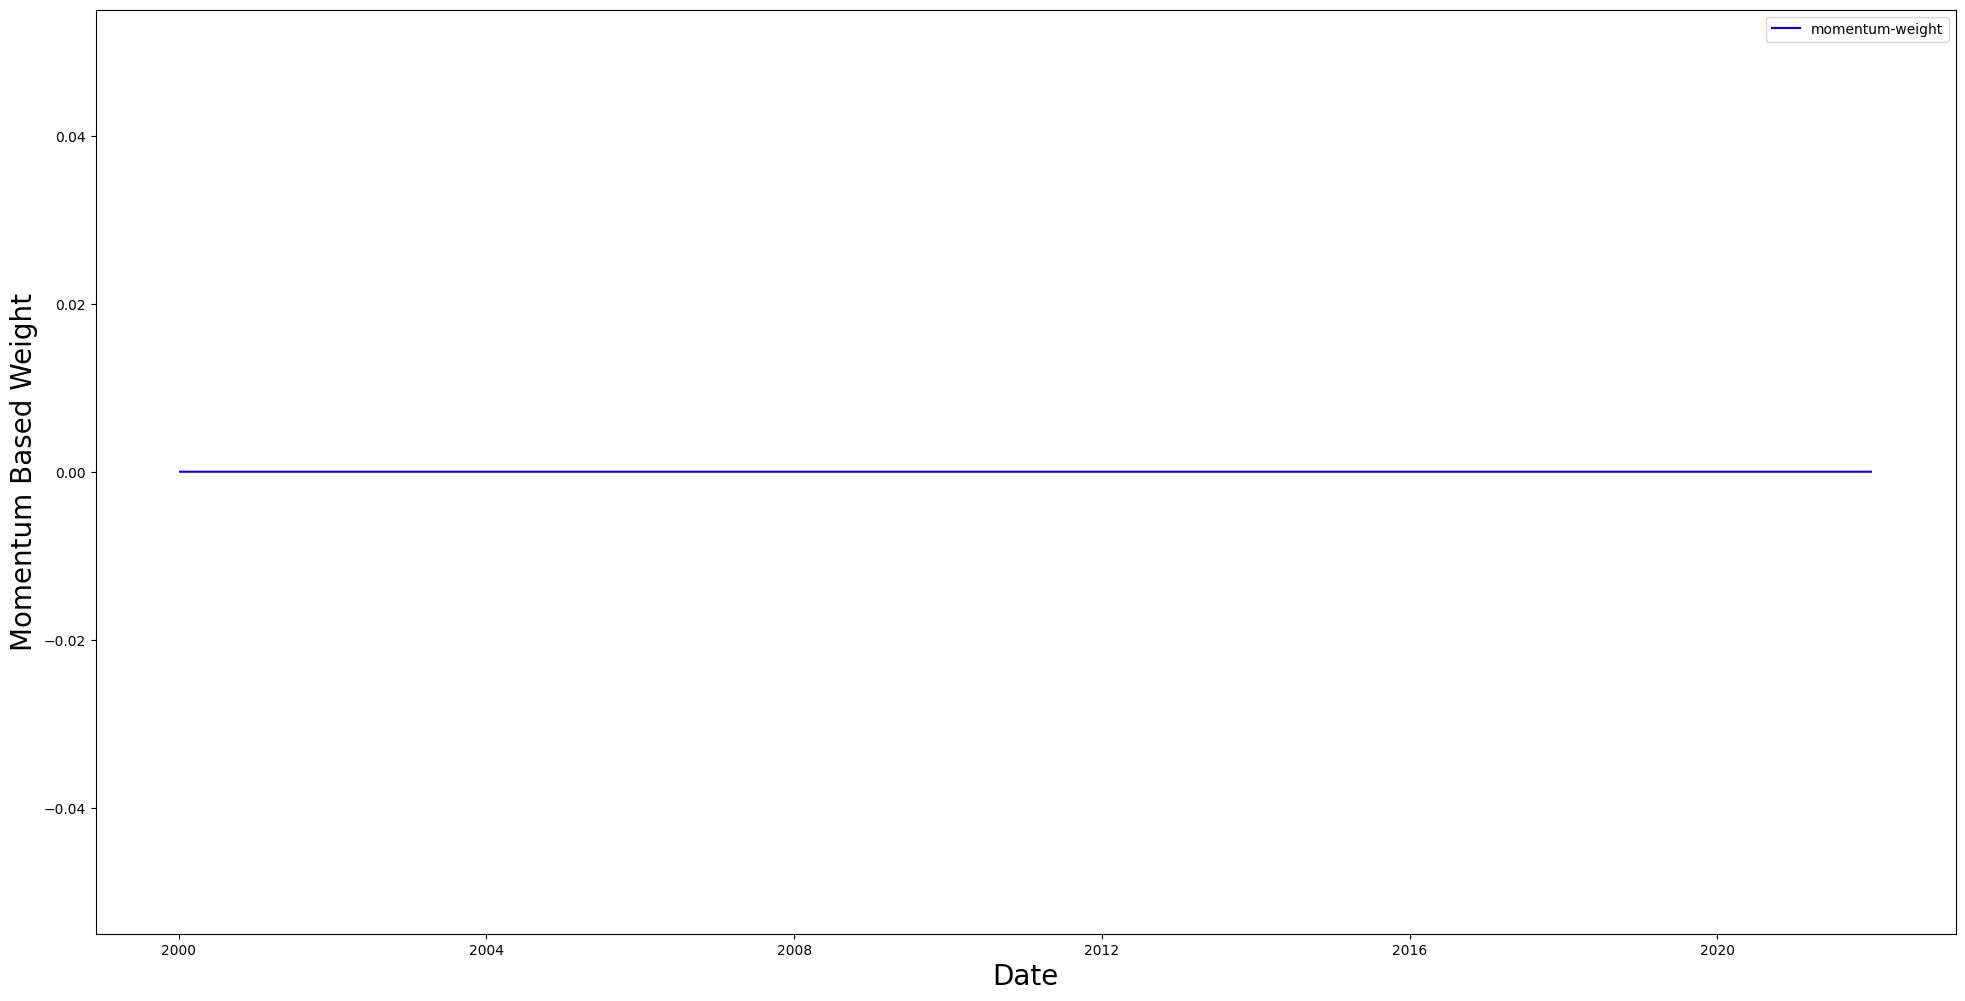

Please Wait...
(5431,)
(5431, 1)


Calculating short_weight...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5431/5431 [00:00<00:00, 15769.13it/s]


Straddle making done! check the result with
 .weight, .long_stock, .short_stock, .long_weight, .short_weight
 .total_weight

### Notice ### .total_weight is lagged 1 day for backtesting to avoid forward-looking bias


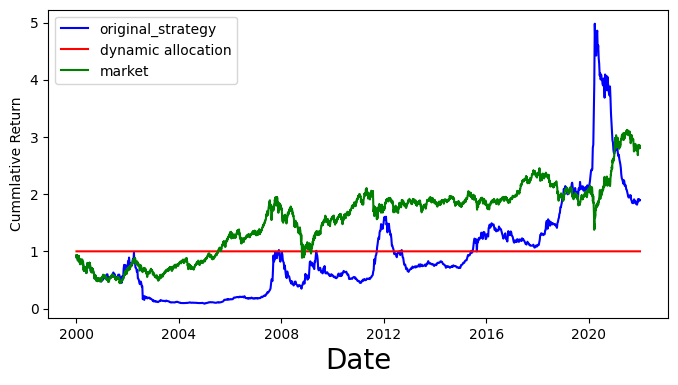

Beta-Asymmetry Strategy
CAGR: [0.03086805]
Sharpe: [0.07316899]
MDD: -0.9135555735533096
VOL: [0.42187347]

Beta-Asymmetry with strategy-based momentum
CAGR: [0.]
Sharpe: [nan]
MDD: 0.0
VOL: [nan]
1990 ~ 2000


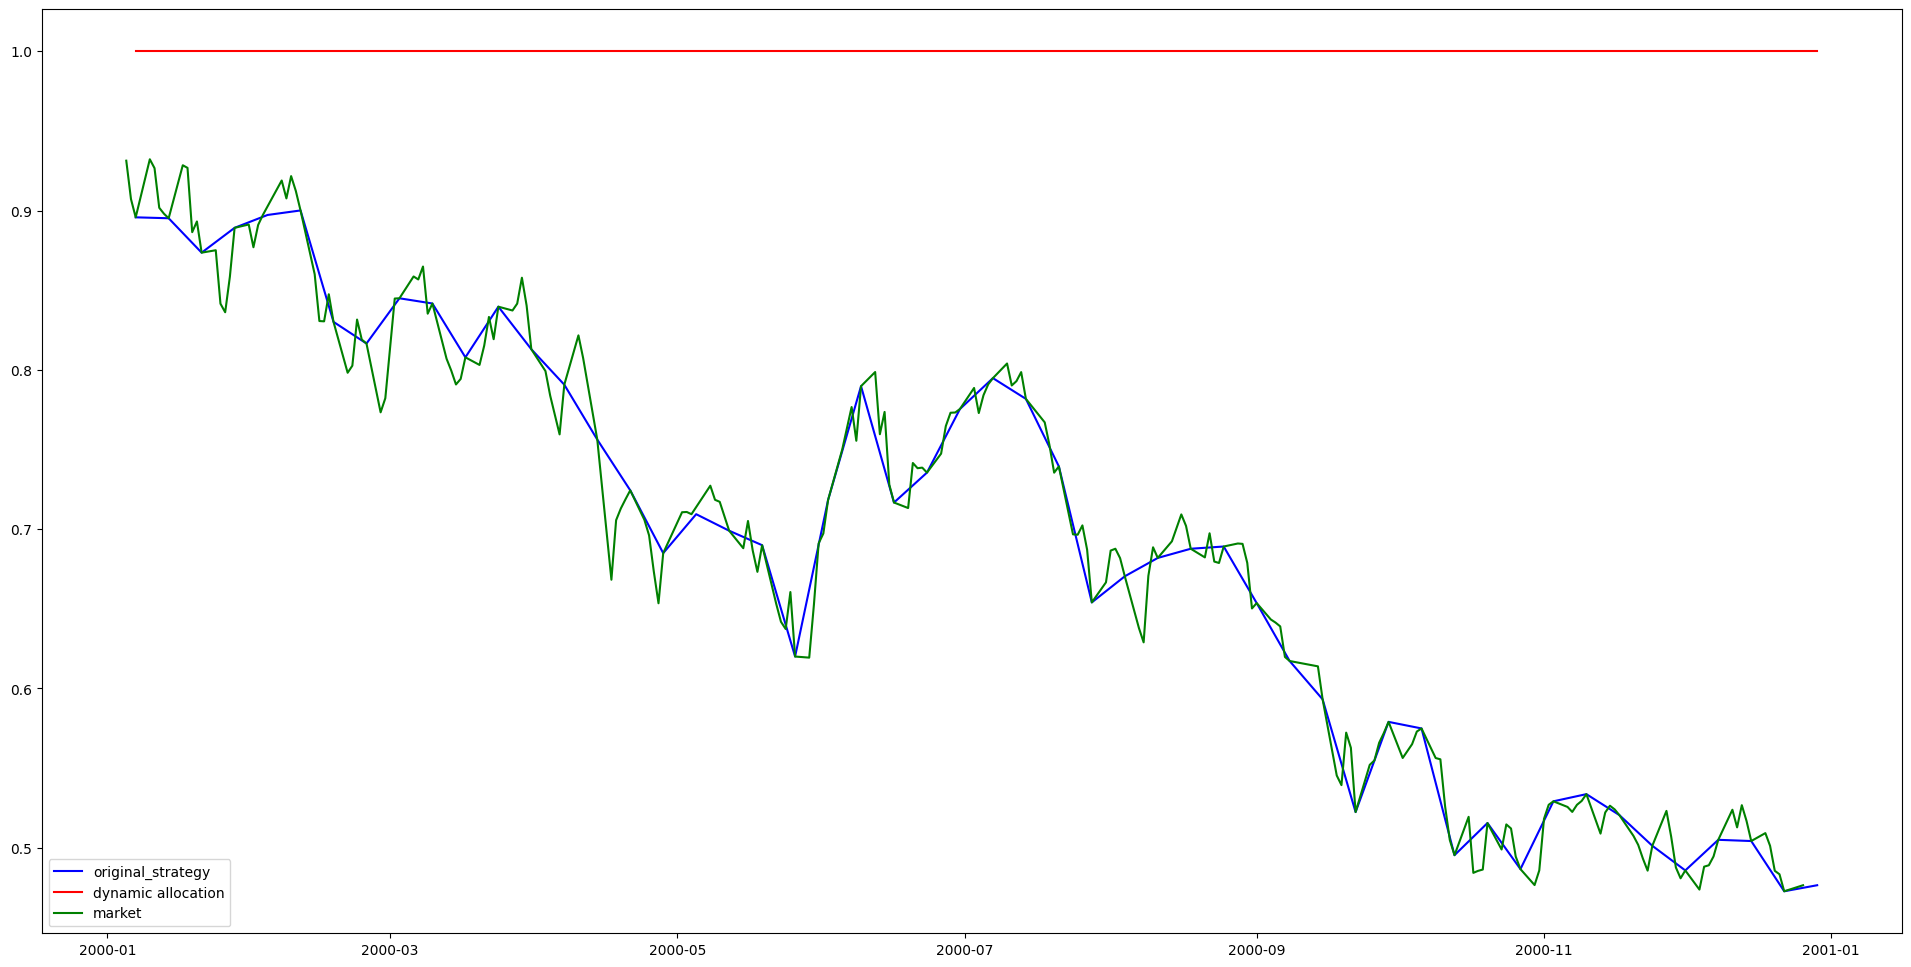

2000 ~ 2010


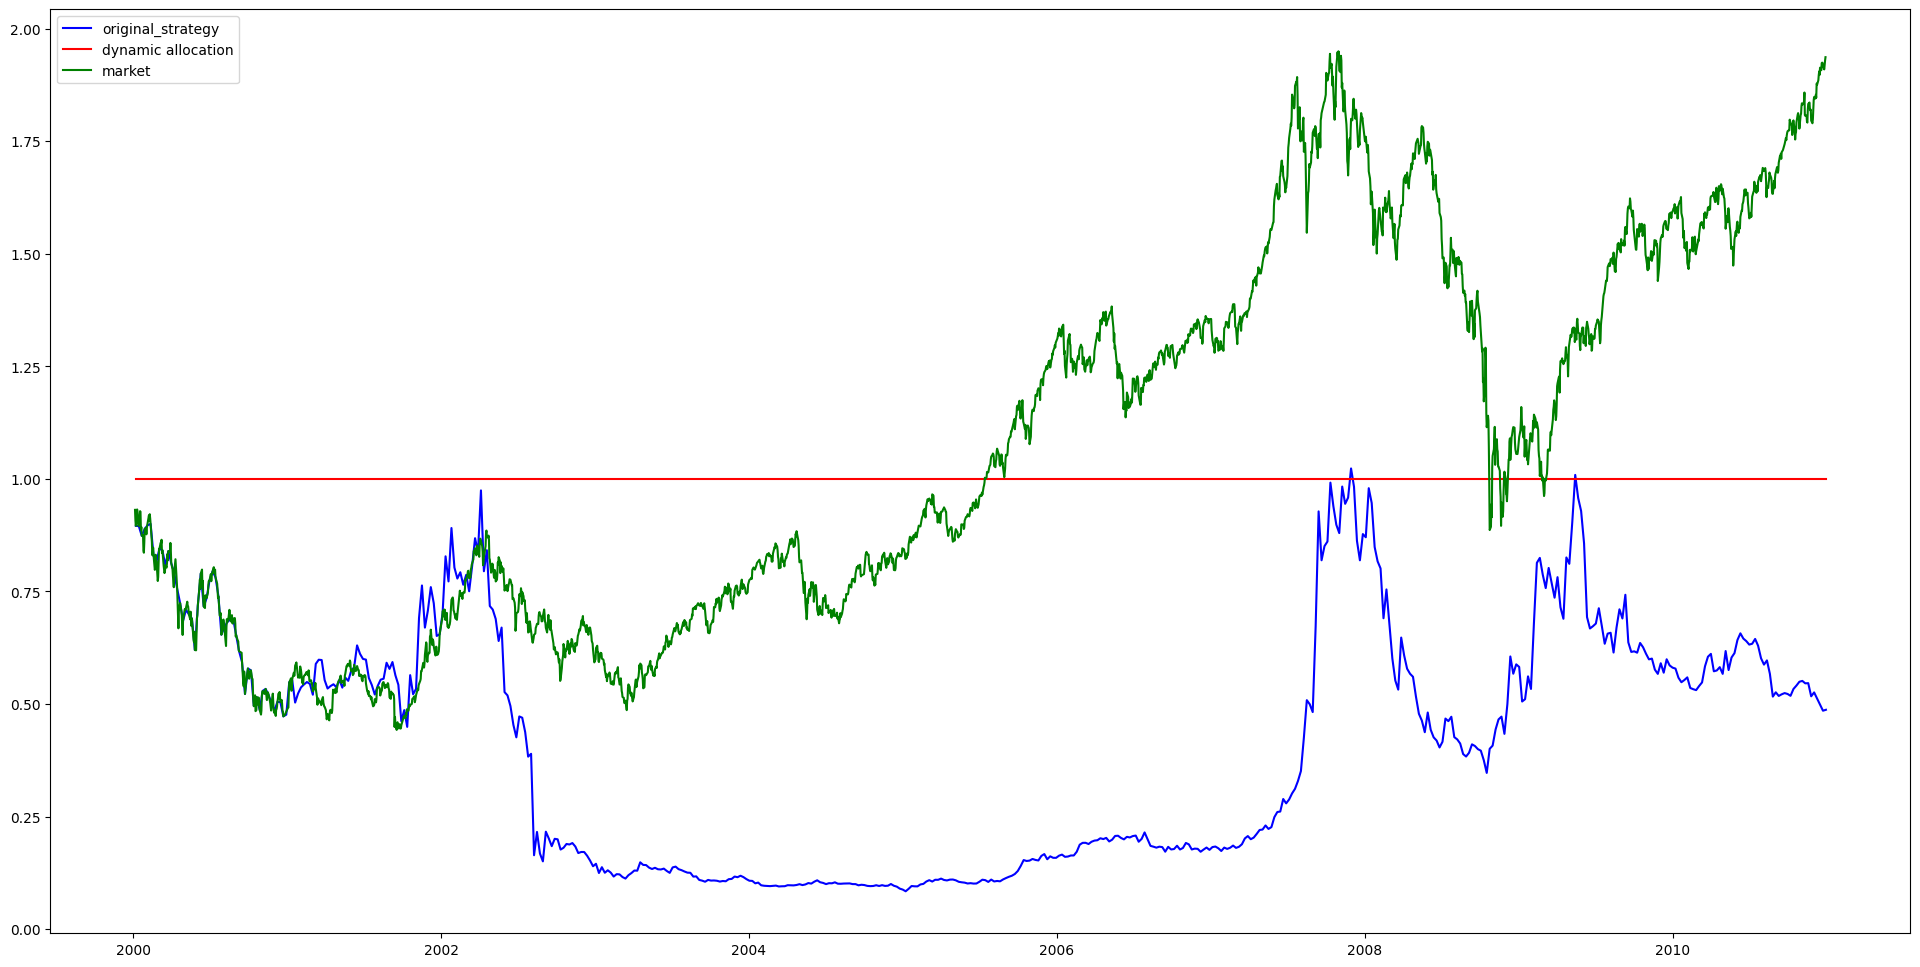

2010 ~ 2020


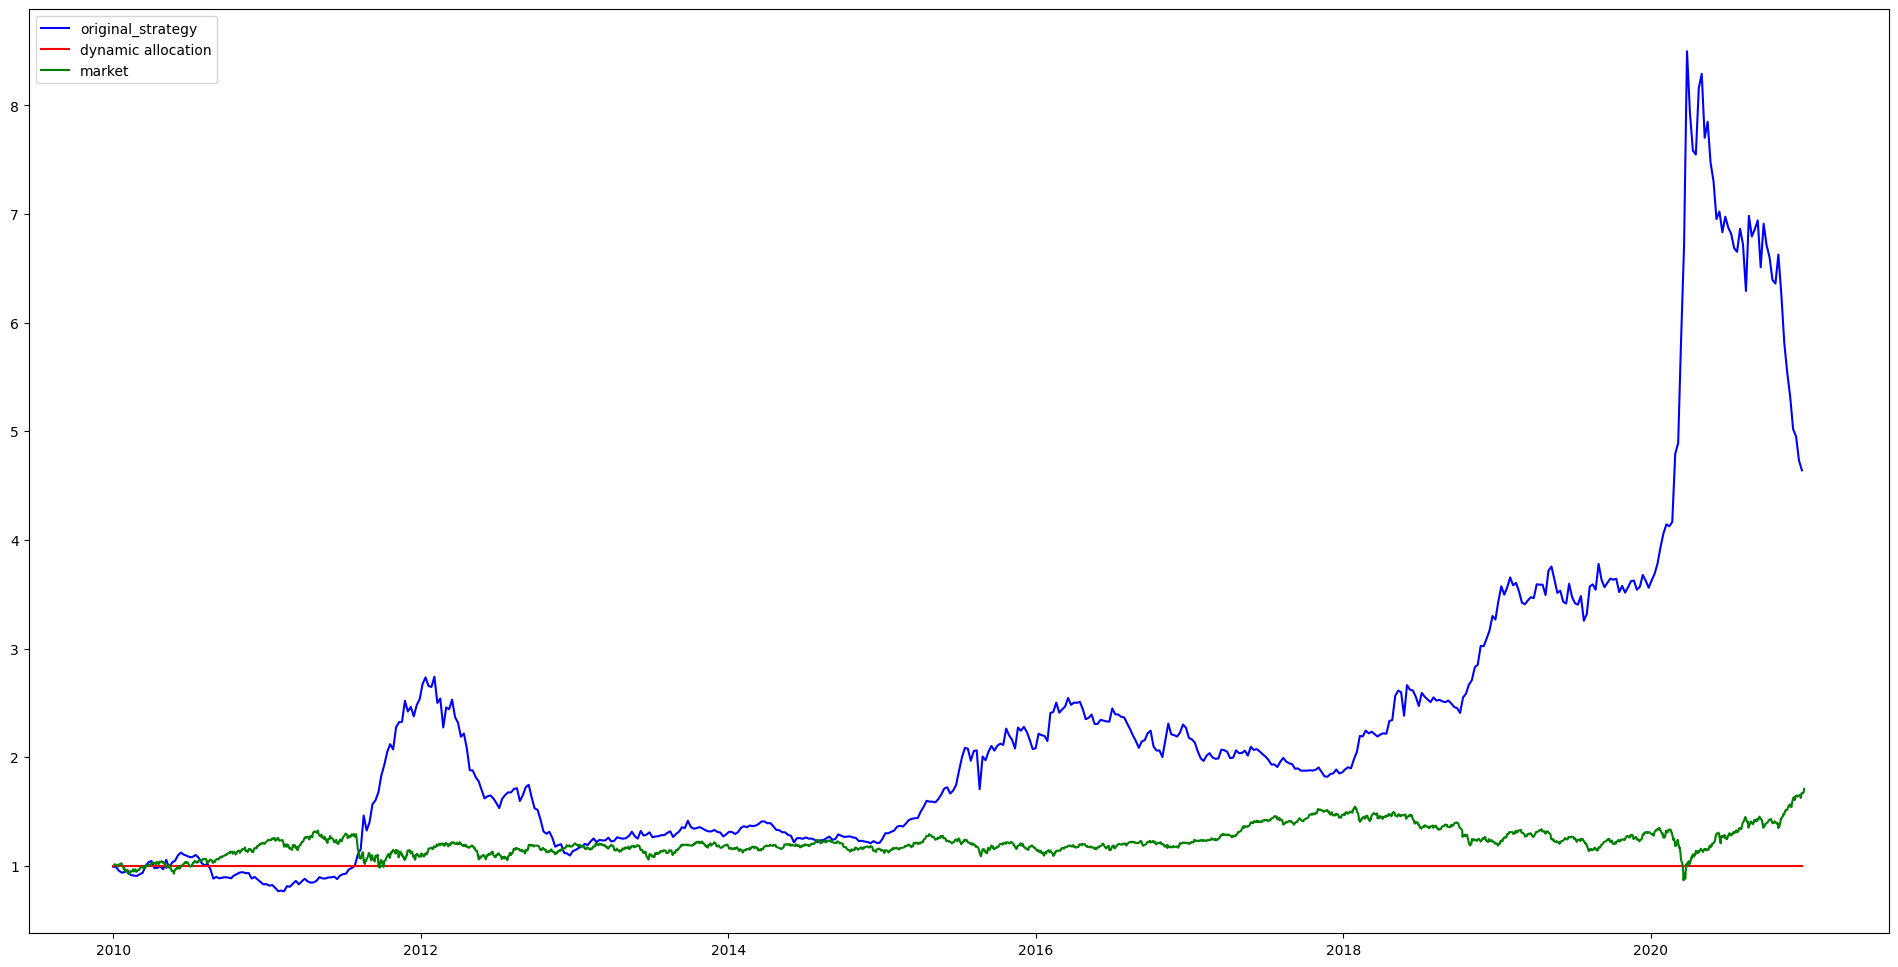

In [110]:
backtest(kr_stock, kr_market, screen = pd.DataFrame([[1]*kr_stock.shape[1]]*kr_stock.shape[0], columns=kr_stock.columns, index=kr_stock.index))